In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


In [2]:
from importlib import reload
import numpy as np
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm, trange
import mmcv
import data
import bbox
from utils import imshownp
import meva
from meva.lib.meva_model import MEVA
from meva.utils import kp_utils
from meva.utils import image_utils
from meva.utils.video_config import update_cfg
from torch.utils.data import DataLoader

/home/tormod/Documents/APEC/meva/utils/transformations.py:1927: UserWarning: No module named 'meva.utils._transformations'
  warnings.warn(str(err))


In [3]:
from importlib import reload
reload(data)

<module 'data' from '/home/tormod/Documents/APEC/data.py'>

In [5]:
c = data.ClimbingDataset('test')

In [6]:
pretrained_file = f"results/meva/train_meva_2/model_best.pth.tar"
config_file = f"meva/cfg/train_meva_2.yml"
cfg = update_cfg(config_file)

In [8]:
batch_size = 6
model = MEVA(
    n_layers=cfg.MODEL.TGRU.NUM_LAYERS,
    batch_size=batch_size,
    seqlen=cfg.DATASET.SEQLEN,
    hidden_size=cfg.MODEL.TGRU.HIDDEN_SIZE,
    add_linear=cfg.MODEL.TGRU.ADD_LINEAR,
    bidirectional=cfg.MODEL.TGRU.BIDIRECTIONAL,
    use_residual=cfg.MODEL.TGRU.RESIDUAL,
    cfg=cfg.VAE_CFG,
)
ckpt = torch.load(pretrained_file, map_location='cpu')
# print(f'Performance of pretrained model on 3DPW: {ckpt["performance"]}')
ckpt = ckpt['gen_state_dict']
model.load_state_dict(ckpt)
model.eval()

loading VAErecV2 model from checkpoint: results/meva/vae_rec_2/models/model_1000.p


MEVA(
  (vae_model): VAErecV2(
    (e_rnn): RNN(
      (rnn_f): GRUCell(144, 256)
      (rnn_b): GRUCell(144, 256)
    )
    (e_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (e_mu): Linear(in_features=512, out_features=512, bias=True)
    (e_logvar): Linear(in_features=512, out_features=512, bias=True)
    (d_rnn): RNN(
      (rnn_f): GRUCell(656, 512)
    )
    (d_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (d_out): Linear(in_features=512, out_features=144, bias=True)
    (init_pose_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (init_p

In [9]:
dataloader = DataLoader(c, batch_size=batch_size, num_workers=16, shuffle = False)

In [36]:
import time
output = {}
pred_cam, pred_verts, pred_pose, pred_betas, pred_joints3d, norm_joints2d = [], [], [], [], [], []
for seqs in dataloader.batch_sampler:
    with torch.no_grad():
        start = time.time()
        feats = torch.stack([torch.Tensor(c[seq]) for seq in seqs])
        output = model(feats)[-1]
        finish = time.time()
        pred_cam.append(output['theta'][:, :, :3])
        pred_verts.append(output['verts'])
        pred_pose.append(output['theta'][:, :, 3:75])
        pred_betas.append(output['theta'][:, :, 75:])
        pred_joints3d.append(output['kp_3d'])
        norm_joints2d.append(output['kp_2d'])
    break
pred_cam = torch.cat(pred_cam, dim=0)
pred_verts = torch.cat(pred_verts, dim=0)
pred_pose = torch.cat(pred_pose, dim=0)
pred_betas = torch.cat(pred_betas, dim=0)
pred_joints3d = torch.cat(pred_joints3d, dim=0)
norm_joints2d = torch.cat(norm_joints2d, dim=0)

pred_cam = pred_cam.cpu().numpy()
pred_verts = pred_verts.cpu().numpy()
pred_pose = pred_pose.cpu().numpy()
pred_betas = pred_betas.cpu().numpy()
pred_joints3d = pred_joints3d.cpu().numpy()
norm_joints2d = norm_joints2d.cpu().numpy()
output_dict = {'pred_cam': pred_cam,
               'verts': pred_verts,
               'pose': pred_pose,
               'betas': pred_betas,
               'joints3d': pred_joints3d,
               'joints2d': norm_joints2d}

In [37]:
(finish-start)*len(c)

16.514545440673828

In [38]:
norm_joints2d.shape

(6, 90, 49, 2)

In [39]:
seqidx = 0
frameid = 10
seqinfo = c.get(seqidx)

/home/tormod/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


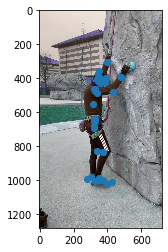

In [40]:
inv_trans = seqinfo['inv_trans'][frameid].copy()
kp_2d = norm_joints2d[seqidx, frameid].copy()
kp_2d *= 1.2
kp_2d = image_utils.normalize_2d_kp(kp_2d, inv=True)
kp_2d = image_utils.trans_points2d(kp_2d, inv_trans)
plt.imshow(seqinfo['raw_imgs'][frameid])
plt.scatter(kp_2d[:,0], kp_2d[:,1])
plt.show();

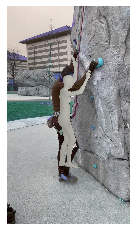

In [71]:
import mesh
verts = pred_verts[seqidx, frameid].copy()
cam = pred_cam[seqidx, frameid].copy()
bboxes = seqinfo['bboxes'].copy()
img = seqinfo['raw_imgs'][frameid].copy()
cam[0] *= 1.2
imshownp(mesh.render_pred_mesh(img, bboxes, verts, cam))

In [27]:
from meva.utils.renderer import Renderer
from meva.utils.demo_utils import convert_crop_cam_to_orig_img
from bbox import cxcywh2cs
from mesh import render_vids
# make mesh vids
# def render_vids(cd, res, out_folder):
#     all_verts = res['verts']
#     all_pred_cam = res['pred_cam']
#     for vid_idx, cumlen in enumerate(np.cumsum(cd.seq_lengths)):
#         vid_name = cd.stripped_names[vid_idx]
#         start = 0 if vid_idx==0 else cumlen[vid_idx-1]
#         orig_height, orig_width, _ = cd.get(start)['raw_imgs'][0].shape
#         renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True)
#         for seqidx in range(start, cumlen):
#             seq_info = cd.get(seqidx)
#             imgs = seq_info['raw_imgs']
#             bboxes = seq_info['bboxes']
#             bboxcs = cxcywh2cs(bboxes, (orig_height, orig_width))
#             bboxcs[:,2:] = bboxes[:,2:]
#             frames = seq_info['frames']
#             frames = np.arange(frames.start, frames.stop)
#             verts = all_verts[seqidx]
#             pred_cam = all_pred_cam[seqidx]
#             orig_cam = convert_crop_cam_to_orig_img(pred_cam, bboxcs, orig_width, orig_height)
#             orig_cam[:,:2] *= 1.2
#             for i, v, oc, f, bb in zip(imgs, verts, orig_cam, frames, bboxes):
#                 mesh_img = renderer.render(i, v, oc)
#                 plt.imshow(mesh_img)
#                 plt.show()
#                 #mmcv.imwrite(mesh_img, f'{out_folder}/{vid_name}/{f:06d}.png')
                
render_vids(c, output_dict, '/media/tormod/Den Lille/Thesis/meva_out')

AttributeError: 'ClimbingDataset' object has no attribute 'stripped_names'